In [78]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import warnings
import time
from warnings import warn
from tqdm.notebook import tqdm,trange # to display loading bars
from scipy.stats import multivariate_normal
from matplotlib.widgets import Slider
from tqdm.notebook import tqdm,trange
%load_ext autoreload
%autoreload 2

from BenamouBrenier import TransportProblem
from transport import gaussian_transport, gaussian_discreatization, random_gaussian_parameters,torus_dist2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# With factorization storing
## Display solution

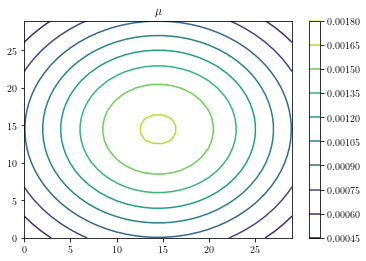

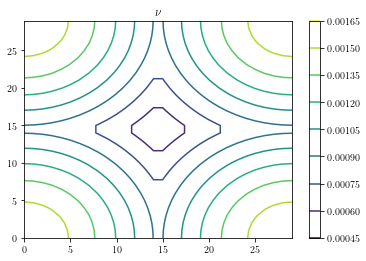

/Users/benoitmuller/opt/anaconda3/lib/python3.9/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


TransportProblem object initialized.


  0%|          | 0/30 [00:00<?, ?it/s]

Benamou-Brenier method converged to tolerance with criterium =3477402452992111104.00


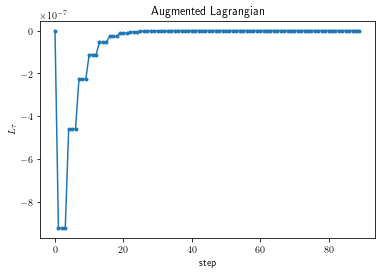

In [79]:
%matplotlib inline
plt.rcParams['text.usetex'] = True

rng = np.random.default_rng(123)
from scipy.stats import multivariate_normal
from matplotlib.widgets import Slider
N=30 #20
T=N
mesh= np.array(np.meshgrid(np.linspace(0,1,N),np.linspace(0,1,N)))

#mean1, cov1 = random_gaussian_parameters(2,rng)
#mean2, cov2 = random_gaussian_parameters(2,rng)
sigma = 0.2 #0.2
mean1 , cov1 = 0.5 * np.ones((2)) , sigma * np.eye(2)
mean2 , cov2 = 1 * np.ones((2)) , sigma * np.eye(2)

mu,nu = np.empty((N,N)),np.empty((N,N))
for idx in np.ndindex((N,N)):
    mu[idx] = np.exp(-0.5*torus_dist2(mesh[(...,*idx)],mean1)/sigma)
    nu[idx] = np.exp(-0.5*torus_dist2(mesh[(...,*idx)],mean2)/sigma)
mu = mu/np.sum(mu)
nu = nu/np.sum(nu)

plt.figure()
plt.contour(mu)
plt.colorbar()
plt.title("$\mu$")
plt.savefig("graphics/mu.pdf")

plt.figure()
plt.contour(nu)
plt.colorbar()
plt.title("$\\nu$")
plt.savefig("graphics/nu.pdf")
plt.show()

prob1 = TransportProblem(mesh,mu,nu,T,tau=100)
criteria,LL = prob1.solve(maxiter=30) #30
plt.plot(LL,'.-')
plt.title("Augmented Lagrangian")
plt.xlabel("step")
plt.ylabel("$L_\\tau$")
plt.savefig("graphics/criteria.pdf")

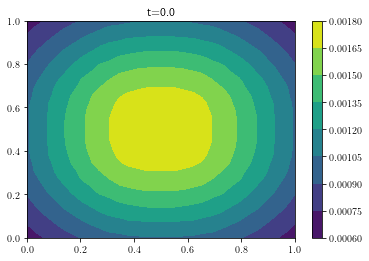

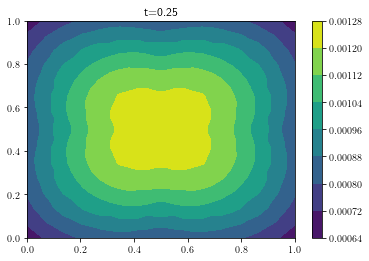

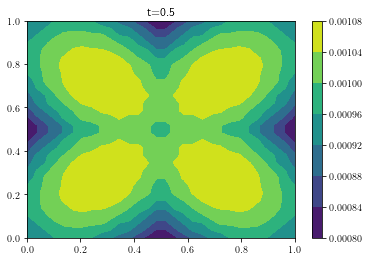

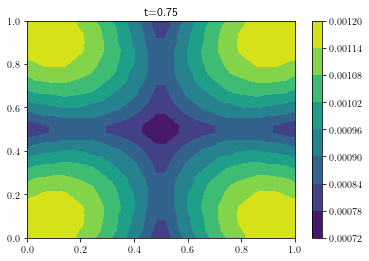

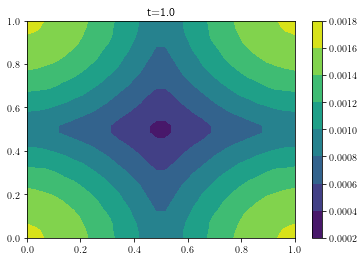

In [80]:
%matplotlib inline
tt= np.linspace(0,1,5)
prob1.plot(tt)

In [81]:
%matplotlib
fig = prob1.plot()

Using matplotlib backend: <object object at 0x7fadbc8a6a70>


## Running time per iteration

In [82]:
%matplotlib inline
rng = np.random.default_rng(1234)
NN = np.linspace(10,20,10).astype(int)
repeat = 3
init_times=np.zeros((len(NN),repeat))
times=np.zeros((len(NN),repeat))

for i,N in tqdm(enumerate(NN),total=len(NN)):
    T=N
    mesh= np.array(np.meshgrid(np.linspace(0,1,N),np.linspace(0,1,N)))
    #mean1, cov1 = random_gaussian_parameters(2,rng)
    #mean2, cov2 = random_gaussian_parameters(2,rng)
    sigma = 0.2
    mean1 , cov1 = 0.5 * np.ones((2)) , sigma * np.eye(2)
    mean2 , cov2 = 1 * np.ones((2)) , sigma * np.eye(2)
    mu,nu = np.empty((N,N)),np.empty((N,N))

    for idx in np.ndindex((N,N)):
        mu[idx] = np.exp(-0.5*torus_dist2(mesh[(...,*idx)],mean1)/sigma)
        nu[idx] = np.exp(-0.5*torus_dist2(mesh[(...,*idx)],mean2)/sigma)

    mu = mu/np.sum(mu)
    nu = nu/np.sum(nu)

    for r in range(repeat):
        tic = time.time()
        prob1 = TransportProblem(mesh,mu,nu,T,tau=1,display=False)
        init_times[i,r] = (time.time()-tic)
        tic = time.time()
        criteria = prob1.solve(maxiter=30, display=False)
        times[i,r] = (time.time()-tic)
tot_times = times + init_times

times = np.vstack((np.mean(times,axis=1),np.std(times,axis=1)))
init_times = np.vstack((np.mean(init_times,axis=1),np.std(init_times,axis=1)))
tot_times = np.vstack((np.mean(tot_times,axis=1),np.std(tot_times,axis=1)))

  0%|          | 0/10 [00:00<?, ?it/s]

/Users/benoitmuller/opt/anaconda3/lib/python3.9/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


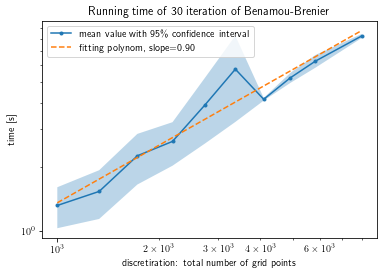

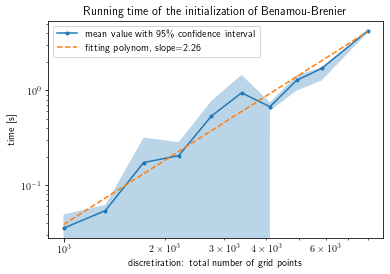

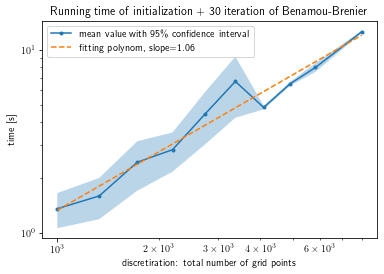

In [83]:
conf_fact = 1.96/np.sqrt(repeat) # 95% confidence for 20 samples

plt.figure()
plt.plot(NN**3,times[0],'.-')
polynom = np.polyfit(np.log(NN**3),np.log(times[0]),deg=1)
plt.plot(NN**3,np.exp(polynom[1])*(NN**3)**polynom[0],"--")
plt.fill_between(NN**3,times[0]-conf_fact*times[1],times[0]+conf_fact*times[1],alpha=0.3)
plt.legend(["mean value with 95\% confidence interval",f"fitting polynom, slope={polynom[0]:.2f}"])
plt.xscale("log")
plt.yscale("log")
plt.xlabel("discretiration: total number of grid points")
plt.ylabel("time [s]")
plt.title(f"Running time of 30 iteration of Benamou-Brenier")
plt.savefig("graphics/BB_runtimeperiteration.pdf")

plt.figure()
plt.plot(NN**3,init_times[0],'.-')
polynom = np.polyfit(np.log(NN**3),np.log(init_times[0]),deg=1)
plt.plot(NN**3,np.exp(polynom[1])*(NN**3)**polynom[0],"--")
plt.fill_between(NN**3,init_times[0]-conf_fact*times[1],init_times[0]+conf_fact*init_times[1],alpha=0.3)
plt.legend(["mean value with 95\% confidence interval",f"fitting polynom, slope={polynom[0]:.2f}"])
plt.xscale("log")
plt.yscale("log")
plt.xlabel("discretiration: total number of grid points")
plt.ylabel("time [s]")
plt.title(f"Running time of the initialization of Benamou-Brenier")
plt.savefig("graphics/BB_runtimeinitialization.pdf")

plt.figure()
plt.plot(NN**3,tot_times[0],'.-')
polynom = np.polyfit(np.log(NN**3),np.log(tot_times[0]),deg=1)
plt.plot(NN**3,np.exp(polynom[1])*(NN**3)**polynom[0],"--")
plt.fill_between(NN**3,tot_times[0]-conf_fact*tot_times[1],tot_times[0]+conf_fact*tot_times[1],alpha=0.3)
plt.legend(["mean value with 95\% confidence interval",f"fitting polynom, slope={polynom[0]:.2f}"])
plt.xscale("log")
plt.yscale("log")
plt.xlabel("discretiration: total number of grid points")
plt.ylabel("time [s]")
plt.title(f"Running time of initialization + 30 iteration of Benamou-Brenier")
plt.savefig("graphics/BB_runtimetotal.pdf")

# Comparing without factorization storing

In [84]:
%matplotlib inline
rng = np.random.default_rng(1234)
N = 20
itit = np.linspace(1,30,5).astype(int)
repeat = 2
times=np.zeros((len(itit),repeat))
times_forget=np.zeros((len(itit),repeat))


T=N
mesh= np.array(np.meshgrid(np.linspace(0,1,N),np.linspace(0,1,N)))
#mean1, cov1 = random_gaussian_parameters(2,rng)
#mean2, cov2 = random_gaussian_parameters(2,rng)
sigma = 0.2
mean1 , cov1 = 0.5 * np.ones((2)) , sigma * np.eye(2)
mean2 , cov2 = 1 * np.ones((2)) , sigma * np.eye(2)
mu,nu = np.empty((N,N)),np.empty((N,N))

for idx in np.ndindex((N,N)):
    mu[idx] = np.exp(-0.5*torus_dist2(mesh[(...,*idx)],mean1)/sigma)
    nu[idx] = np.exp(-0.5*torus_dist2(mesh[(...,*idx)],mean2)/sigma)

mu = mu/np.sum(mu)
nu = nu/np.sum(nu)
for i,it in tqdm(enumerate(itit),total=len(itit)):
    for r in range(repeat):
        tic = time.time()
        prob1 = TransportProblem(mesh,mu,nu,T,tau=1,display=False)
        criteria = prob1.solve(maxiter=it, display=False)
        times[i,r] = (time.time()-tic)

        tic = time.time()
        prob1 = TransportProblem(mesh,mu,nu,T,tau=1,Afactorized=False,display=False)
        criteria = prob1.solve(maxiter=it, display=False)
        times_forget[i,r] = (time.time()-tic)

times = np.vstack((np.mean(times,axis=1),np.std(times,axis=1)))
times_forget = np.vstack((np.mean(times_forget,axis=1),np.std(times_forget,axis=1)))

  0%|          | 0/5 [00:00<?, ?it/s]

/Users/benoitmuller/opt/anaconda3/lib/python3.9/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/Users/benoitmuller/opt/anaconda3/lib/python3.9/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:144: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


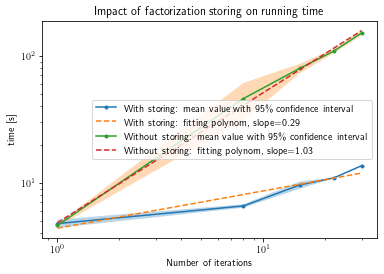

In [85]:
conf_fact = 1.96/np.sqrt(repeat) # 95% confidence for 20 samples

plt.figure()

plt.plot(itit,times[0],'.-')
polynom1 = np.polyfit(np.log(itit),np.log(times[0]),deg=1)
plt.plot(itit,np.exp(polynom1[1])*itit**polynom1[0],"--")

plt.plot(itit,times_forget[0],'.-')
polynom2 = np.polyfit(np.log(itit),np.log(times_forget[0]),deg=1)
plt.plot(itit,np.exp(polynom2[1])*itit**polynom2[0],"--")

plt.legend(["With storing: mean value with 95\% confidence interval",
            f"With storing: fitting polynom, slope={polynom1[0]:.2f}",
            "Without storing: mean value with 95\% confidence interval",
            f"Without storing: fitting polynom, slope={polynom2[0]:.2f}"])

plt.fill_between(itit,times[0]-conf_fact*times[1],
                 times[0]+conf_fact*times[1],alpha=0.3)
plt.fill_between(itit,times_forget[0]-conf_fact*times_forget[1],
                 times_forget[0]+conf_fact*times_forget[1],alpha=0.3)

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Number of iterations")
plt.ylabel("time [s]")
plt.title(f"Impact of factorization storing on running time")
plt.savefig("graphics/BB_runtimewithoutstore.pdf")

# Uniform measure

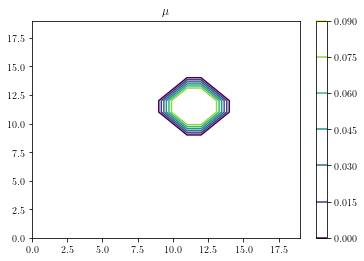

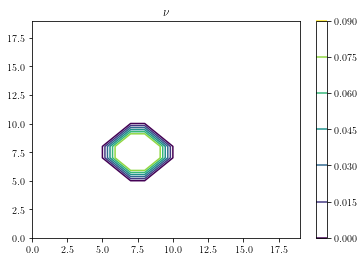

In [86]:
%matplotlib inline
plt.rcParams['text.usetex'] = True

rng = np.random.default_rng(123)
from scipy.stats import multivariate_normal
from matplotlib.widgets import Slider
N=20 #20
T=N
mesh= np.array(np.meshgrid(np.linspace(0,1,N),np.linspace(0,1,N)))

c1,c2 = np.array([0.6,0.6]), np.array([0.4,0.4])
r1,r2 = 0.1,0.1

mu,nu = np.empty((N,N)),np.empty((N,N))
for idx in np.ndindex((N,N)):
    mu[idx] = int(torus_dist2(mesh[(...,*idx)],c1)<r1**2)
    nu[idx] = int(torus_dist2(mesh[(...,*idx)],c2)<r2**2)
mu = mu/np.sum(mu)
nu = nu/np.sum(nu)

plt.figure()
plt.contour(mu)
plt.colorbar()
plt.title("$\mu$")
plt.savefig("graphics/mu.pdf")

plt.figure()
plt.contour(nu)
plt.colorbar()
plt.title("$\\nu$")
plt.savefig("graphics/nu.pdf")
plt.show()

/Users/benoitmuller/opt/anaconda3/lib/python3.9/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


TransportProblem object initialized.


  0%|          | 0/50 [00:00<?, ?it/s]

Benamou-Brenier method converged to tolerance with criterium =-1755066.46


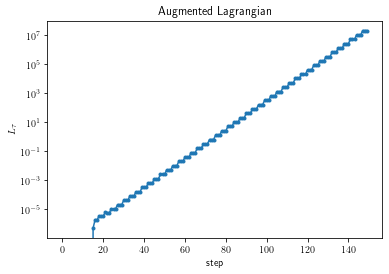

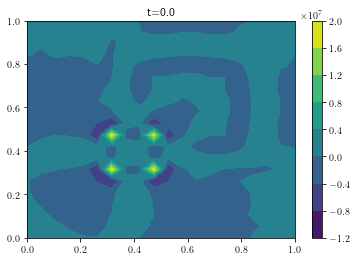

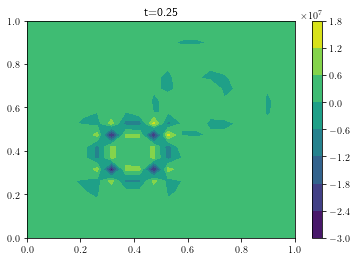

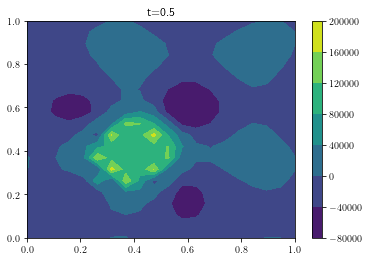

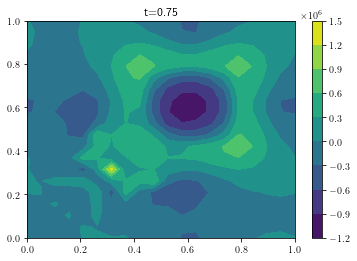

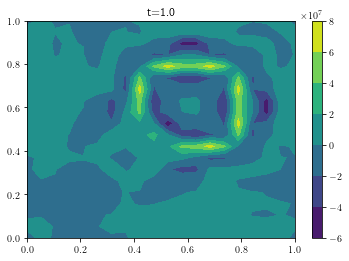

In [87]:
prob1 = TransportProblem(mesh,mu,nu,T,tau=1)
criteria,LL = prob1.solve(maxiter=50) #30
plt.semilogy(LL,'.-')
plt.title("Augmented Lagrangian")
plt.xlabel("step")
plt.ylabel("$L_\\tau$")
plt.savefig("graphics/criteria.pdf")
prob1.plot(np.linspace(0,1,5))